In [135]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.cm as cm
import matplotlib.pyplot as plt

import itertools

In [7]:
df = pd.read_csv("../data/hr_neighbors.csv")

print df.head()
print "total number of lines =", len(df)

df_clean = df[(df.rssi<0) & (df.distance>0)]

df_clean.loc[:, "date"] = pd.to_datetime(df_clean.time, unit='s')

lines_removed = len(df) - len(df_clean)

print "number of lines removed = ", lines_removed, "(", float(lines_removed)*100/len(df), "% )"
print "Data from ", df_clean.date.iloc[0], "to", df_clean.date[len(df_clean.date)-1]

print len(df.groupby("mac"))

         time                      mac              neighborMac  neighborFlag  \
0  1479034272  00-17-0d-00-00-38-00-63  00-17-0d-00-00-30-5d-39             0   
1  1479034272  00-17-0d-00-00-38-00-63  00-17-0d-00-00-38-03-dd             0   
2  1479035172  00-17-0d-00-00-38-00-63  00-17-0d-00-00-30-5d-39             0   
3  1479035172  00-17-0d-00-00-38-00-63  00-17-0d-00-00-38-03-dd             0   
4  1479036071  00-17-0d-00-00-38-00-63  00-17-0d-00-00-30-5d-39             0   

   rssi  numTxPackets  numTxFailures  numRxPackets mote_board ngbr_board  \
0   -59            63              1             2      huron        NaN   
1   -31            60              0             2      huron      huron   
2   -57            62              2             2      huron        NaN   
3   -32            62              0             2      huron      huron   
4   -57            63              1             1      huron        NaN   

   distance  
0     11.66  
1      0.09  
2     11.66  


2017-02-07 14:16:04
18


## Link Asymmetry

In [8]:
# removing non DC9008 boards
df_reduced = df_clean[
    (df_clean["mote_board"] == "DC9003A-B")
    & (df_clean.ngbr_board == "DC9003A-B")
]


def get_hash(A, B):
    return ''.join(sorted([A, B]))

def check_hash(A, B, hash):
    if ''.join([A, B]) == hash:
        return True
    else:
        return False

df_reduced["hash"] = df_reduced.apply(lambda row: (get_hash(row["mac"], row["neighborMac"])), axis=1)

df_indexed = df_reduced.set_index(df_reduced["date"])

hash_grouped = df_indexed.groupby(["hash"])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [170]:
diff_list = []
diff_list2 = []

# for each link
for hash, group in hash_grouped:
    AtoB = []
    BtoA = []
    
    # resample and separate A->B and B->A links
    for m, gr in group.groupby(group["mac"]):
        rssi_resampled = gr.rssi.resample('1h').mean()
        
        if check_hash(gr["mac"][0], gr["neighborMac"][0], hash):
            AtoB = rssi_resampled
        else:
            BtoA = rssi_resampled
    
    # compute RSSI difference for each time bin
    rssi_diff = pd.Series(AtoB).subtract(pd.Series(BtoA)).dropna()

    # only select link with important traffic
    if len(rssi_diff) > 1000:
        diff_list.append([str(gr["mac"][0]), str(gr["neighborMac"][0]), len(rssi_diff),
                          abs(rssi_diff.mean()), rssi_diff.std(), rssi_diff])       

print "Total number of nodes:", len(df_indexed.groupby(["mac"]))
print "Total number of active links:", len(diff_list)
print "Total number of HR_NEIGHBORS:", df_clean.count()[1]
print "Active links between ", df_clean.date.iloc[0], "and", df_clean.date[len(df_clean.date)-1]

Total number of nodes: 15
Total number of active links: 9
Total number of HR_NEIGHBORS: 365460
Active links between  2016-11-13 10:51:12 and 2017-02-07 14:16:04


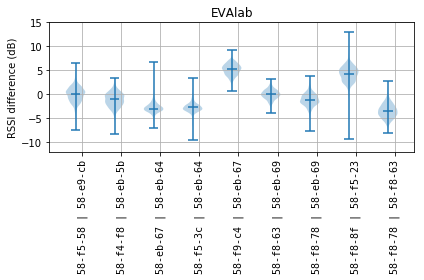

In [172]:
df_final = pd.DataFrame(diff_list, columns=["mac_1", "mac_2", "count", "mean", "std", "vals"])
df_final.set_index(["mac_1", "mac_2"], inplace=True)

ind = np.arange(len(df_final.index))
bar_width = 0.35

plt.violinplot(df_final["vals"].values, ind,
    showmeans=False, showmedians=True
    )
plt.xticks(ind + bar_width / 2, [str(i[0])[-8:]+ " | " +str(i[1])[-8:] for i in df_final.index],
           rotation=90, fontname="monospace")

plt.ylabel('RSSI difference (dB)')
plt.ylim([-12, 15])

plt.title("EVAlab")
plt.grid(True)
plt.tight_layout() # make sure xlabels are not cut off

plt.savefig("../figures/asymmetry.eps", format='eps')
plt.show()